In [ ]:
#white car + shadows

test_images/extra-251.jpg


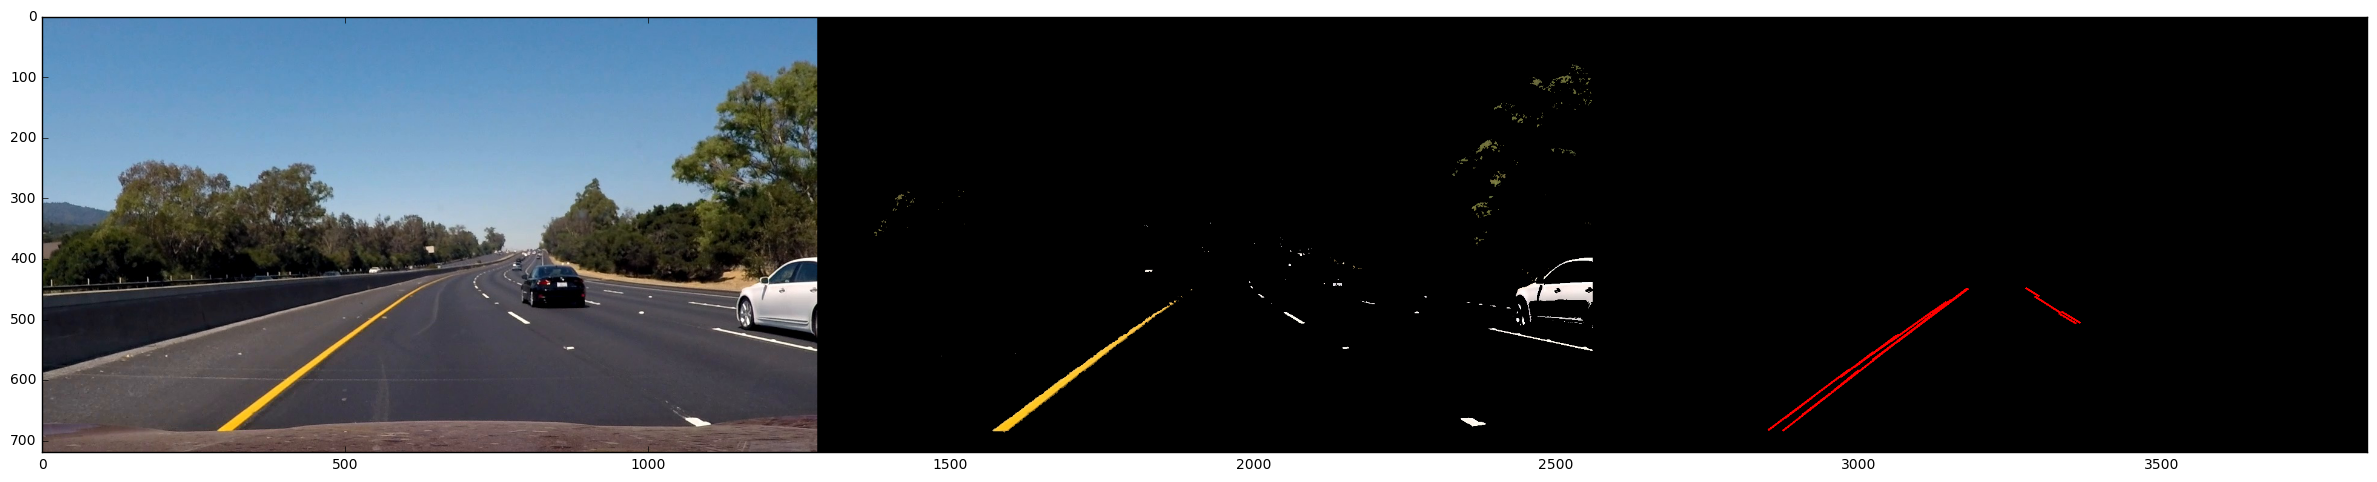

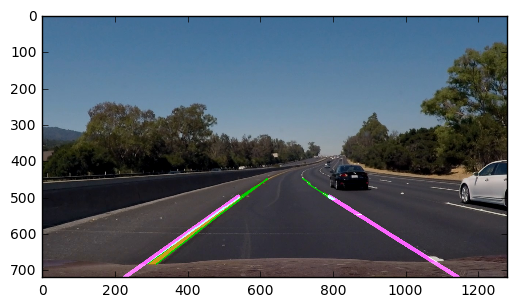

In [1]:
import math
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, color=[255,0,0]):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines, color = color)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def lane_mask(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)       
    ymask = cv2.inRange(hsv,  np.array([50, 100, 100]), np.array([100, 255, 255]))  
    wmask = cv2.inRange(image, np.array([200,200,200]), np.array([255,255,255]))
        
    mask = cv2.bitwise_or(ymask, wmask)
    res = cv2.bitwise_and(image, image, mask = mask)
    return res

def pass1(image):
    return grayscale(lane_mask(image))

def pass2(image):
    blur=7
    return gaussian_blur(image, blur)

def pass3(image):
    canny_threshold=30  
    return canny(image, canny_threshold, canny_threshold)

def lines(image, draw=True, color=[255,0,0]):
    rho= 3 #distance in pixels
    theta=np.pi/180.0 #angle resolution of the acc in radians
    threshold=60
    min_line_len=10
    max_line_gap=20
    
    i = pass3(pass2(pass1(image)))
    
    vertices = np.array([[(0,image.shape[0]),(450, 290), (490, 290), (image.shape[1],image.shape[0])]], dtype=np.int32)
    region = region_of_interest(i, vertices)
                
    if draw:         
        return hough_lines(region, rho, theta, threshold, min_line_len, max_line_gap, color = color)
    else:               
        return cv2.HoughLinesP(region, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
def slope(a):
    x1, y1, x2, y2 = a.reshape((4,))
    if x1 != x2:
        return (y2-y1)/(x2-x1)        
    else:
        return None
    
def bottom_x(a, y):
    s = slope(a)
    x1, y1, x2, y2 = a.reshape((4,))
    if s:
        return x1 + (y-y1)/s # x coordinate for line at given y
    else:
        #vertical line, x1 same as x2
        return x1
    
def length(a):
    x1, y1, x2, y2 = a.reshape((4,))
    return math.hypot(x2-x1, y2-y1)
    

def intersection(lane1_x0, lane1_y0, lane1_slope, lane2_x0, lane2_y0, lane2_slope):
    y1 = 300 #any value could do
    #print('slopes:', lane1_slope, lane2_slope)
    #print(lane1_x0, lane1_y0, lane1_slope, lane2_x0, lane2_y0, lane2_slope)    
    
    lane1_x1 = int(lane1_x0 + (y1 - lane1_y0)/lane1_slope)
    lane2_x1 = int(lane2_x0 + (y1 - lane2_y0)/lane2_slope)
    
    A1 = y1 - lane1_y0
    B1 = lane1_x0 - lane1_x1
    C1 = A1 * lane1_x0 + B1 * lane1_y0
    
    A2 = y1 - lane2_y0
    B2 = lane2_x0 - lane2_x1
    C2 = A2 * lane2_x0 + B2 * lane2_y0
    
    det = A1*B2 - A2*B1
    if det != 0:
        x2 = (B2*C1 - B1*C2)/det
        y2 = (A1*C2 - A2*C1)/det
        return [x2, y2]
    else:
        raise #parallel lines

        
def lane(segments, max_x, max_y, lane_x_range, slope_range):    
    bin_pixels = 40
    num_bins = int(0.5 * max_x/bin_pixels)        

    # currently we use this range only to distinguish between left and right lanes
    # so the left lane is on the left-half of the x-axis
    lane_range = range(lane_x_range[0], lane_x_range[1])    

    # calculate x-coordinate of intersection between extension of segment
    # and bottom line. 
    bottom = np.array([int(bottom_x(x, max_y)) for x in segments])
    slopes = np.array([slope(x) for x in segments])
    #lengths = np.array([length(x) for x in segments])
    weights = np.array([ (abs(max(x[0][1], x[0][3]) - max_y)**1.3 + max(length(x), 150)**2) for x in segments])
        
    idx = [i for i, x in enumerate(segments) 
                if slopes[i] is not None
                and slope_range[0] <= slopes[i] <= slope_range[1]
                and bottom[i] in lane_range] 
        
    if 0 == len(idx):
        raise Exception({
            'error': 'no segments matching criteria',
            'lane_range': lane_range,
            'bottom': bottom,
            'slope_range': slope_range,
            'slopes': slopes,
            'segments': segments
            })                
    
        
    # to find out whether each segments corresponds to a line
    counts, bins = np.histogram(bottom[idx], bins=num_bins, range=lane_x_range, weights=weights[idx])    
    #print(counts, bins)
    
    assert(0 < len(counts))
    
    #TODO: handle empty sequence here, maybe repeat with different parameters.
    if len(counts) == 0:
        # debugging.
        #print('bin:', int(max_x/bin_width))
        #print('bottom:', bottom)        
        raise Exception("oops")
     
    
    in_range = [i for i,v in enumerate(zip(counts, bins)) if v[0] > 0]
    
    if 0 == len(in_range):
        #TODO
        print('#### failed here:')
        print('SEGMENTS', segments)        
        print('LANERANGE ', lane_range)
        print('HIST:', counts, bins)
        print('???', [v for i,v in enumerate(zip(counts, bins))])
    
    # the the x-bin with most occurrences -- all lines reaching this area will be averaged.
    i_left = np.argmax(counts)
    lane_bin = range(int(bins[i_left]), int(bins[i_left+1]))        
    #print('bin:', llane_bin)
    #print('raw slopes:', [(slope(x),bottom_x(x, max_y)) for x in segments])
    
    indices_within = [i for i in idx if bottom[i] in lane_bin]
    
    # all slopes for lines reaching selected bin
    lane_slopes = slopes[indices_within]  
    assert 0 < len(lane_slopes)
    
    # all x positions for lines reaching selected bin
    lane_xs = bottom[indices_within]
    assert 0 < len(lane_xs)
    
    lane_weights = weights[indices_within]
    assert 0 < len(lane_weights)
    
    
    #print('slopes:', llane_slopes)
    #print('xs:', llane_xs)
    
    # 
    # a lane is defined here by the slope and the position
    # on the line defined by y=max_y (bottom of the image)
    if len(lane_slopes)==0:
        #debugging
        print('LEN SLOPES ZERO.,,,,')
        #print('slopes:', slopes)
        #print('bottom:', bottom)
        #print('BIN:', llane_bin)
        #print('HISTT:', counts, bins)
        #print('raw slopes:', [(slope(x),bottom_x(x, max_y)) for x in segments])        

    
    #print(lane_lengths)
    #print(lane_slopes)
    mean_slope = np.average(lane_slopes.astype(np.float), weights=lane_weights.astype(np.float))    
    assert abs(mean_slope) > 0.1, lane_slopes
    assert ~np.isnan(mean_slope)
    
    mean_xs = int(np.average(lane_xs.astype(np.float), weights=lane_weights.astype(np.float)))
    assert mean_xs > 0, lane_xs
    return mean_slope, mean_xs
    
def lanes(segments, max_x, max_y):   
    #print('SEGMENTS LEN:', len(segments))
    left_slope, left_x = lane(segments, max_x, max_y, (0, int(max_x/2)), (-0.9, -0.1))
    right_slope, right_x = lane(segments, max_x, max_y, (int(max_x/2), max_x), (0.1, 0.9)) 
    
    #print('slopes', left_slope, right_slope)
    
    # in the first version I was drawing lanes that intersect in the horizon,
    # not sure why I thought it was part of the exercise.
    #left lane: x0, y0, slope
    #right lane: x1, y1, slope
    horizon = intersection(left_x, max_y, left_slope, right_x, max_y, right_slope) 
    
    y1 = horizon[1] * 1.2 #give some margin to look prettier on curves
    left_x1 = int(left_x + (y1 - max_y)/left_slope)
    right_x1 = int(right_x + (y1 - max_y)/right_slope)

    
    lines = []        
    #lines.append([[int(left_x), int(max_y), int(horizon[0]), int(horizon[1])]])    
    #lines.append([[int(right_x), int(max_y), int(horizon[0]), int(horizon[1])]])
    lines.append([[int(left_x), int(max_y), int(left_x1), int(y1)]])    
    lines.append([[int(right_x), int(max_y), int(right_x1), int(y1)]])    
    return lines

def lane_overlay(image):
    img2 = np.zeros_like(image)
    max_y = img2.shape[0]
    max_x = img2.shape[1]
    color = [200, 50, 255]
    #color = [255, 0, 0]
    draw_lines(img2, lanes(lines(image, draw=False),  max_x, max_y), color = color, thickness=10)
    return img2
    
def lane_overlay_averaged(image, previous):
    img2 = np.zeros_like(image)
    max_y = img2.shape[0]
    max_x = img2.shape[1]
    color = [200, 50, 255]
    #color = [255, 0, 0]
    current = lanes(lines(image, draw=False), max_x, max_y)
    if previous:
        for i, (c,p) in enumerate(zip(current, previous)):
            for j in range(4):
                v= c[0][j]
                w = p[0][j]
                current[i][0][j] = int( (v+w)/2 )                
    draw_lines(img2, current, color = color, thickness=10)
    return img2, current
    
    
def sideBySide(filename):
    image=mpimg.imread(filename)            
    return np.hstack([image, weighted_img(lane_overlay(image), image)])    

def sideBySideDebug(filename):
    image=mpimg.imread(filename)            
    #return pass3(pass2(pass1(image)))
    return np.hstack([image, lane_mask(image), lines(image)])
    #return np.hstack([image, lane_mask(image), weighted_img(lane_overlay(image), image)])    

filenames = ['test_images/' + f for f in os.listdir("test_images") if f.endswith('jpg')]
#filenames = [x for x in filenames if x.startswith('test_images/error')]
filenames = ['test_images/extra-251.jpg']
for i, f in enumerate(filenames[:1]):
    print(f)
    
    debug = sideBySideDebug(f)
    plt.figure(figsize=(30,30))    
    plt.imshow(debug)

    image=mpimg.imread(f)            
    lines2 = [x for x in lines(image, draw=False)]    
    for row in lines2:
        l = row[0]
        #print(l)        
        cv2.line(image, (l[0], l[1]), (l[2], l[3]), (0,255,0), 2)    
    plt.figure()
    #plt.imshow(image)
    plt.figure()
    plt.imshow(weighted_img(lane_overlay(image), image))
    #print(lanes(lines2, 960, 540))
    #plt.imshow(pass2(pass1(image)))
    #plt.imshow(lane_mask(image))
        
    #image = mpimg.imread('test_images/' + f)
    #mage_with_lanes = weighted_img(image, lane_overlay(image))
    #lt.imshow(image_with_lanes)
    #mpimg.imsave('test_images/output/' + f, image_with_lanes)

    


In [2]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

process_debug = True 
error_count = 0
frame_count = 0

previous = None

def process_image(image):  
    global error_count, frame_count, previous
    frame_count += 1
    try:    
        #print('####' + str(frame_count))
        #mpimg.imsave("test_images/extra-{}.jpg".format(frame_count), image)
        overlay, previous = lane_overlay_averaged(image, previous)
        output = weighted_img(image, overlay)                
        #mpimg.imsave("test_images/extra-{}-output.jpg".format(frame_count), output)
        return output
    except Exception as e:
        print('####' + str(frame_count))
        print(e)
        error_count += 1        
        if process_debug:            
            mpimg.imsave("test_images/error-{}.jpg".format(error_count), image)
        return image




In [3]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:12<00:00, 17.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1min 20s, sys: 3.35 s, total: 1min 24s
Wall time: 13.1 s


In [4]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)




[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:42<00:00, 15.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 4min 32s, sys: 11.9 s, total: 4min 44s
Wall time: 43.8 s


In [5]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


 59%|█████▉    | 148/251 [00:13<00:13,  7.45it/s]

####1053
{'lane_range': range(640, 1280), 'segments': array([[[223, 682, 471, 539]],

       [[224, 681, 469, 534]],

       [[286, 655, 396, 575]],

       [[246, 685, 310, 640]],

       [[498, 521, 517, 510]],

       [[322, 619, 431, 556]],

       [[314, 632, 472, 534]],

       [[251, 662, 356, 601]],

       [[315, 633, 407, 577]],

       [[361, 602, 470, 534]],

       [[249, 660, 270, 648]],

       [[579, 473, 592, 465]],

       [[308, 640, 357, 608]],

       [[249, 659, 268, 648]],

       [[244, 685, 297, 651]],

       [[495, 518, 513, 508]],

       [[280, 660, 291, 653]],

       [[429, 564, 441, 557]],

       [[250, 664, 308, 630]],

       [[506, 516, 517, 509]],

       [[442, 557, 473, 537]]], dtype=int32), 'slopes': array([-0.5766129 , -0.6       , -0.72727273, -0.703125  , -0.57894737,
       -0.57798165, -0.62025316, -0.58095238, -0.60869565, -0.62385321,
       -0.57142857, -0.61538462, -0.65306122, -0.57894737, -0.64150943,
       -0.55555556, -0.63636364, -

 60%|█████▉    | 150/251 [00:14<00:17,  5.69it/s]

####1055
{'lane_range': range(640, 1280), 'segments': array([[[230, 685, 488, 524]],

       [[243, 682, 278, 661]],

       [[562, 480, 579, 469]],

       [[247, 668, 373, 595]],

       [[358, 611, 420, 574]],

       [[235, 686, 275, 661]],

       [[295, 645, 370, 600]],

       [[287, 644, 416, 566]],

       [[377, 599, 424, 570]],

       [[571, 475, 586, 466]],

       [[459, 547, 487, 530]],

       [[407, 575, 490, 525]],

       [[242, 678, 372, 600]],

       [[310, 631, 425, 562]],

       [[564, 481, 590, 465]],

       [[301, 645, 426, 567]],

       [[299, 637, 486, 524]],

       [[417, 570, 490, 526]],

       [[304, 644, 428, 567]]], dtype=int32), 'slopes': array([-0.62403101, -0.6       , -0.64705882, -0.57936508, -0.59677419,
       -0.625     , -0.6       , -0.60465116, -0.61702128, -0.6       ,
       -0.60714286, -0.60240964, -0.6       , -0.6       , -0.61538462,
       -0.624     , -0.60427807, -0.60273973, -0.62096774]), 'bottom': array([173, 179, 191, 157, 

100%|██████████| 251/251 [00:27<00:00,  6.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 2min 34s, sys: 7.07 s, total: 2min 41s
Wall time: 28.6 s
